In [1]:
from __future__ import print_function
import json
import zipfile
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import ndimage
import descartes
import geopandas as gpd
import seaborn as sns
import googlemaps
import gmaps
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MultiLabelBinarizer
porter = PorterStemmer()
lancaster=LancasterStemmer()

sns.set_style('darkgrid')
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
# desc: plot histogram according to the param Series and a name 
def histplot(data, name=None, title=None, kde_flag=True, hist_kws=None):
    plt.figure(figsize = (6,4))
    sns.distplot(data, kde=kde_flag, hist_kws=hist_kws).set(xlabel = name +" histogram", title = title)
    
# desc: use RE to filter (clean) text features for further processing (ie. stemming)  
def clean_text(list_t):
    temp = []
    for text in list_t:
        # remove backslash-apostrophe 
        text = re.sub("\'", "", text) 
        # remove everything except alphabets 
        text = re.sub("[^a-zA-Z]"," ",text) 
        # remove whitespaces 
        text = ' '.join(text.split()) 
        # convert text to lowercase 
        text = text.lower() 
        temp.append(text)
    
    return temp

# desc: find outliers from data according to a threshold, return their indeces
def findOutlierIndex(data, threshold):
    z = np.abs(stats.zscore(data))
    index_outliers = np.where(z > threshold)
    return index_outliers


In [3]:
# load data from zip file
d = None  
data = None  
with zipfile.ZipFile("train.json.zip", "r") as z:
   for filename in z.namelist():    
      with z.open(filename) as f:  
         data = f.read()  
         d = json.loads(data.decode("utf-8"))
        
data = pd.DataFrame.from_dict(d)

rental_train = data.copy()

# <b>Exploratory data analysis(Use the training dataset to perform EDA)</b>
*  <font size="3"> Plot histograms for the following numeric columns: Price, Latitude & Longitude. </font>
*  <font size="3"> Plot hour-wise listing trend and find out the top 5 busiest hours of postings. </font>
*  <font size="3"> Visualization to show the proportion of target variable values. </font>


In [4]:
print(rental_train.shape)
numOfRow = rental_train.shape[0]
# clean price
price_front_percentile = np.percentile(rental_train.price, 0.5)
price_end_percentile = np.percentile(rental_train.price, 99.5)
price_clean = rental_train[(rental_train['price'] < np.int(price_end_percentile)) & (rental_train['price'] > np.int(price_front_percentile))]

price_clean = price_clean['price']

# clean lat&lon
lat_up = 40.95
lat_down = 40.5
lon_left = -74.1
lon_right = -73.8

lat_clean = rental_train[ (lat_up >= rental_train['latitude']) & (rental_train['latitude'] >= lat_down)]
lon_clean = rental_train[ (lon_right >= rental_train['longitude']) & (rental_train['longitude'] >= lon_left)]
lat_lon_clean = rental_train[ (lat_up >= rental_train['latitude']) & (rental_train['latitude'] >= lat_down) & (lon_right >= rental_train['longitude']) & (rental_train['longitude'] >= lon_left)]
print("number of records cleaned out by lat: ", numOfRow-lat_clean.shape[0])
print("number of records cleaned out by lon: ", numOfRow-lon_clean.shape[0])
print("number of records cleaned out by lat and lon: ", numOfRow-lat_lon_clean.shape[0])


lat_clean = lat_clean['latitude']
lon_clean = lon_clean['longitude']




(49352, 15)
number of records cleaned out by lat:  44
number of records cleaned out by lon:  109
number of records cleaned out by lat and lon:  113


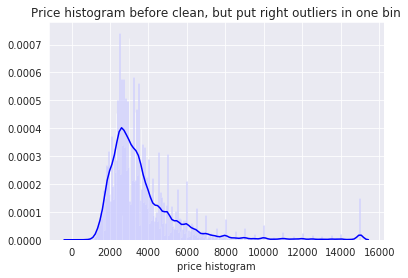

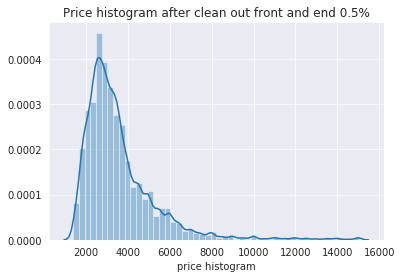

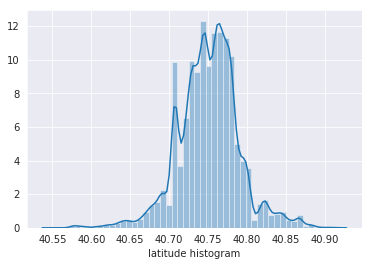

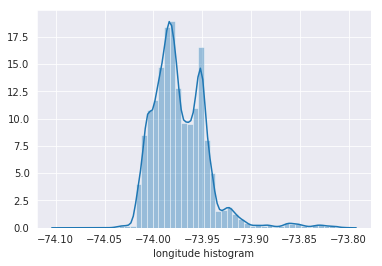

In [5]:
# 1. Plot histograms for the following numeric columns: Price, Latitude & Longitude.
sns.distplot(np.clip(rental_train["price"], 0, 15000), bins=333, color='b', hist_kws=dict(alpha=0.5)).set(xlabel = "price histogram", title='Price histogram before clean, but put right outliers in one bin')

histplot(price_clean, name='price', title='Price histogram after clean out front and end 0.5%')
# histplot(lat_clean, 'latitude')
# histplot(lon_clean, 'longitude')

histplot(lat_lon_clean['latitude'], 'latitude')
histplot(lat_lon_clean['longitude'], 'longitude')

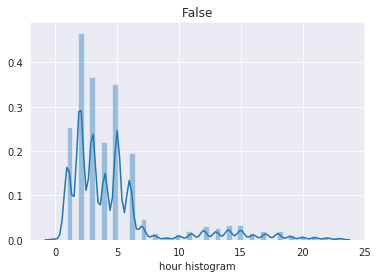

In [6]:
# 2.Plot hour-wise listing trend and find out the top 5 busiest hours of postings. 
rental_train['created'] = pd.to_datetime(rental_train['created'])
# rental_train.iloc[0]['created']
rental_train['created_hour'] = rental_train['created'].dt.hour
histplot(rental_train['created'].dt.hour, 'hour', False)

# counts_df = pd.Series(range(24))
counts = np.zeros(24)
for i in range(rental_train.shape[0]):
    counts[rental_train.iloc[i]['created'].hour-1] += 1 
counts = pd.Series(counts)

In [7]:
counts.index = np.arange(1, len(counts)+1)
print("the top 5 busiest hours of postings:\ntime counts")
print(counts.nlargest(5))

the top 5 busiest hours of postings:
time counts
2    10596.0
3     8318.0
5     7954.0
1     5749.0
4     5021.0
dtype: float64


Text(0.5, 1.0, 'Barplot of Interest Level')

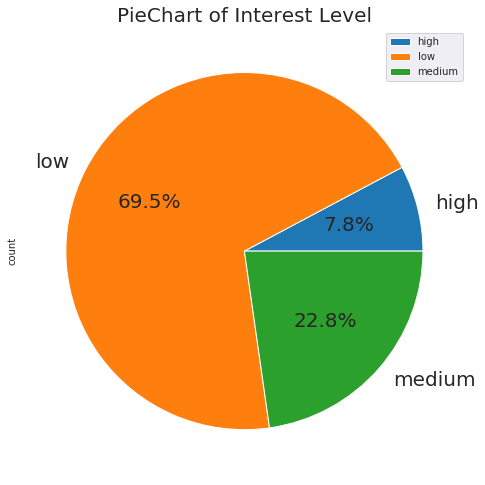

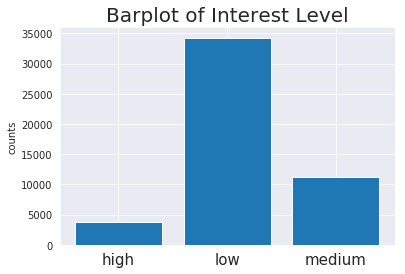

In [8]:
# 3.Visualization to show the proportion of target variable values. 
rental_train_group = rental_train.groupby('interest_level')
rental_train_group.size()
interests = pd.DataFrame(rental_train_group.size())
interests.columns = ['count']
interests.plot.pie(y='count',figsize=(8,10),fontsize=20,autopct='%1.1f%%')
plt.title('PieChart of Interest Level', fontsize=20)

plt.figure(figsize = (6,4))
index = pd.Series.tolist(interests.index)
value = pd.Series.tolist(rental_train_group.size())
y_pos = np.arange(len(index))
plt.bar(y_pos, value)
plt.xticks(y_pos, index,fontsize=15)
plt.ylabel('counts')
plt.title('Barplot of Interest Level', fontsize=20)

Price before excluding price outliers:
                price                      
                 min      max         mean
interest_level                            
high             700   111111  2700.293045
low               43  4490000  4176.599142
medium           695    15000  3158.767388 

Price after excluding price outliers:
                price                    
                 min    max         mean
interest_level                          
high            1395  13200  2732.488998
low             1395  15046  3804.771755
medium          1395  15000  3167.790999


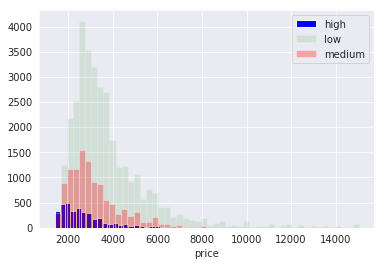

In [9]:
#*4.Extract prices of each interest level and visaulize them accordingly

# before excluding price outliers
print("Price before excluding price outliers:\n",rental_train_group.agg({'price':['min','max','mean']}),"\n")

# after cleaning
price_front_percentile = np.percentile(rental_train.price, 0.5)
price_end_percentile = np.percentile(rental_train.price, 99.5)

price_clean = rental_train[(rental_train['price'] < np.int(price_end_percentile)) & (rental_train['price'] > np.int(price_front_percentile))]
print("Price after excluding price outliers:\n",price_clean.groupby('interest_level').agg({'price':['min','max','mean']}))

# separated histograms of prices after cleaning
high = price_clean[price_clean['interest_level']=='high']
low = price_clean[price_clean['interest_level']=='low']
medium = price_clean[price_clean['interest_level']=='medium']

sns.distplot(high['price'], color='b', kde=False, hist_kws=dict(alpha=1))
sns.distplot(low['price'], color='g', kde=False, hist_kws=dict(alpha=0.1))
sns.distplot(medium['price'], color='r', kde=False, hist_kws=dict(alpha=0.3)).legend(['high','low','medium'])

# plt.figure(figsize = (6,4))
# sns.boxplot(x='interest_level', y='price', data=rental_train)

In [10]:
# Visualize each record on a google map of NYC
import gmaps

with open('API_key.txt') as f:
    api_key = f.readline()
    f.close

gmaps_key = googlemaps.Client(key=api_key)

lat_lon_clean = lat_lon_clean[['latitude', 'longitude']]

sample_coordinates = lat_lon_clean.sample(frac=0.05, replace=False, random_state=1)

gmaps.configure(api_key=api_key)

lat_lon_layer = gmaps.symbol_layer(
    sample_coordinates, fill_color='green', stroke_color='green', scale=2
)
fig = gmaps.figure()
fig.add_layer(lat_lon_layer)
fig


FileNotFoundError: [Errno 2] No such file or directory: 'API_key.txt'

# <b> Dealing with missing values,outliers</b>
*  <font size="3">  Find out the number of missing values in each variable. </font>
*  <font size="3">  Find out the number of outliers in each variable. Plot visualizations to
    demonstrate them.You can either remove the outliers or provide a
    short argument as to why outlier detection is not meaningful for that attribute. </font>
*  <font size="3">  Can we safely drop the missing values? If not, how will you deal withthem? </font>


Number of missing values in either zero bathrooms or zero bedrooms: 9631
Number of missing values in buildingID: 8286
Number of missing values in created_hour: 0
Number of missing values in either zero latitude or zero longitude: 12
Number of missing values in managerID: 0
Number of missing values in price: 0
Number of price outliers: 513


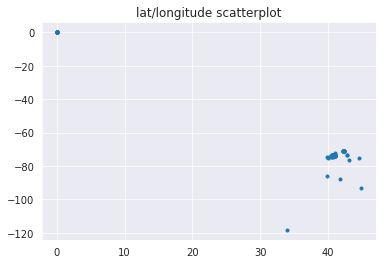

In [11]:
'''
    1.Find out the number of missing values in each variable.
    2.Find out the number of outliers in each variable. 
      Plot visualizations to demonstrate them.
      You can either remove the outliers or provide a short argument as to why outlier detection is not meaningful for that attribute.
    3.Can we safely drop the missing values? If not, how will you deal withthem?
'''

# zero bath/bedroom value would not be considered as "missing", 
# and possible outliers are reansonalbe therefore not dropped
bath_bed_missing = rental_train[(rental_train['bathrooms'] == 0.0) | (rental_train['bedrooms'] == 0.0)]
print("Number of missing values in either zero bathrooms or zero bedrooms:", len(bath_bed_missing))

# missing value of buildingID would not be dropped, as they can be recovered, or they are somewhat irrelavant 
# (and no numerical outliers)
buildingID_missing = rental_train[rental_train['building_id'] == "0"]
print("Number of missing values in buildingID:", len(buildingID_missing))

# created_hour have no missing data
# and possible outliers are reansonalbe therefore not dropped
created_hour_missing = rental_train[rental_train['created_hour'] == None]
print("Number of missing values in created_hour:", len(created_hour_missing))

# outliers & missing values in lat/longitude could be fixed by street address therefore not dropped
lat_lon_missing = rental_train[(rental_train['latitude']==0.0) | (rental_train['longitude']==0.0)]
print("Number of missing values in either zero latitude or zero longitude:", len(lat_lon_missing))

#sns.scatterplot(x='latitude', y='longitude', data=rental_train).set(title='lat/longitude scatterplot')
plt.scatter(rental_train['latitude'], rental_train['longitude'],marker='.')
plt.title('lat/longitude scatterplot')

# ManagerID have no missing data
# (and no numerical outliers)
# (considering to extract names from these IDs)
managerID_missing = rental_train[rental_train['manager_id'] == '0']
print("Number of missing values in managerID:", len(managerID_missing))
#print(rental_train.groupby('manager_id').count())

# price have no missing data, 
# but the outlier could be dropped as intuitively, they would contribute very little to the classifier
price_missing = rental_train[rental_train['price'] == 0]
print("Number of missing values in price:", len(price_missing))
print("Number of price outliers:", numOfRow-len(price_clean))

# Other missing values(and possible outliers) in text (ie, address, description) would be further processed
# so that they could be decided to drop or not. 
# (Mostly not, as shown in the next step that no value would not be considered as missing)



In [12]:
# Following are the statistical(according to Z-score) outliers of lat, lon, and price 
Outlier_indexlist = findOutlierIndex(rental_train['latitude'], 1.5)
print("\nLatitude outliers (threshold 1.5):\ntotal number: ", len(Outlier_indexlist[0]), "\nIndex     value")
print(rental_train.ix[Outlier_indexlist]['latitude'])

Outlier_indexlist = findOutlierIndex(rental_train['longitude'], 1.5)
print("\nLongitude outliers (threshold 1.5):\ntotal number: ", len(Outlier_indexlist[0]), "\nIndex     value")
print(rental_train.ix[Outlier_indexlist]['longitude'])

Outlier_indexlist = findOutlierIndex(rental_train['price'], 0.5)
print("\nPrice outliers (threshold 0.5):\ntotal number: ", len(Outlier_indexlist[0]), "\nIndex     value")
print(rental_train.ix[Outlier_indexlist]['price'])
rental_train.ix[Outlier_indexlist].index


Latitude outliers (threshold 1.5):
total number:  30 
Index     value
872       42.3459
2028       0.0000
4719      42.8724
16405     44.6038
18267     43.0346
24747     42.3459
37426      0.0000
39046     42.2019
39134      0.0000
39798     34.0126
41022     42.2019
46941      0.0000
49884      0.0000
57131     42.2019
62409     42.3033
63688      0.0000
66197      0.0000
69423      0.0000
70841      0.0000
72896     41.7530
73065     42.3033
76934      0.0000
78568     44.8835
80360     42.3459
81815     42.8725
85521      0.0000
85995     42.3459
106350     0.0000
114889    42.2019
117255    42.2509
Name: latitude, dtype: float64

Longitude outliers (threshold 1.5):
total number:  29 
Index     value
872       -71.0794
2028        0.0000
17977     -72.1336
18267     -76.6336
24747     -71.0794
37426       0.0000
39046     -70.9846
39134       0.0000
39798    -118.2710
41022     -70.9846
46941       0.0000
49884       0.0000
57131     -70.9846
62409     -71.2133
63688       0.0000
6

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/sit

Index(['514', '1187', '1918', '2471', '2513', '2625', '3078', '3755', '4620',
       '4653',
       ...
       '120945', '121039', '121641', '121821', '122319', '122897', '123427',
       '123672', '123877', '123909'],
      dtype='object', length=333)

In [13]:
rental_train = rental_train.drop(rental_train.ix[Outlier_indexlist].index)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


# <b> Feature extraction from images and text</b>
* <font size="3"> Extract features from the images and transform it into data that’s ready to be
    used in the model for classification. </font>
* <font size="3"> Extract features from the text data and transform it into data that’s ready to be
    used in the model for classification. </font>


In [14]:
# 1.Extract features from the images and transform it into data that’s ready to be used in the model for classification.

# Get number of photos of each rental posting 
def count_num_photos(photo_list):
    return len(photo_list)

rental_train['num_photos'] = rental_train['photos'].apply(count_num_photos)
rental_train.head()

# Other approaches are in the Logo_extraction.ipynb and is briefly discussed in report.

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,created_hour,num_photos
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,5,12
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,5,6
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,15,6
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium,7,5
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,3,4


In [15]:
# 2.Extract features from the text data and transform it into data that’s ready to be used in the model for classification. 

data['features'] = data['features'].apply(lambda x : clean_text(x))

ps = PorterStemmer()
def porter_stemmer(list_t):
    temp = []
    for i in list_t:
        temp.append(ps.stem(i))
    return temp

data['stemmed_features'] = data['features'].apply(porter_stemmer)

dic = {}
for i in range(len(data)):
    for j in data["stemmed_features"][i]:
        if j in dic:
            dic[j]+=1
        else:
            dic.setdefault(j,1)
            
dic = {key:val for key, val in dic.items() if val > 5000}
values = dic.values()

In [16]:
#plt.boxplot(values)

In [17]:
keys = list(dic.keys())

for i in keys:
    data[i] = 0
    
for index,words in enumerate(data['stemmed_features']):
    for i in words:
        if i in keys:
            data[i][index] = 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [18]:
# features extracted from text, stored as binary values in the last 15 columns 
data

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,hardwood floor,dogs allow,cats allow,doorman,elev,no fe,laundry in unit,fitness cent,roof deck,outdoor spac
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[dining room, pre war, laundry in building, di...",40.7108,7170325,-73.9539,...,1,1,1,0,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[doorman, elevator, laundry in building, dishw...",40.7513,7092344,-73.9722,...,1,0,0,1,1,1,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[doorman, elevator, laundry in building, laund...",40.7575,7158677,-73.9625,...,1,0,0,1,1,0,1,0,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[doorman, elevator, fitness center, laundry in...",40.7439,7225292,-73.9743,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[elevator, dishwasher, hardwood floors]",40.8433,6824800,-73.9396,...,1,0,0,0,1,0,0,0,0,0
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[common outdoor space, cats allowed, dogs allo...",40.8198,6813268,-73.9578,...,0,1,1,1,1,1,0,0,0,0
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[dining room, elevator, pre war, laundry in bu...",40.5765,6927093,-73.9554,...,1,1,1,0,1,1,1,0,0,0
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[pre war, laundry in unit, dishwasher, no fee,...",40.7448,6892816,-74.0017,...,0,0,0,0,0,1,1,0,0,1
